In [1]:
# -*- coding: utf-8 -*-
# 基本モジュール
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm
#import pandas_profiling

import time
import datetime
import dateutil.parser #変数の時間型への変換で使用
from dateutil.relativedelta import relativedelta

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='meiryo.ttc')
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def grep_startswith(lst,word):
    tgt = []
    for string in lst:
        if string.startswith(word) == True:
            tgt.append(string)
    return tgt

def grep_endswith(lst,word):
    tgt = []
    for string in lst:
        if string.endswith(word) == True:
            tgt.append(string)
    return tgt

def grep_not_startswith(lst,word):
    tgt = []
    for string in lst:
        if string.startswith(word) == False:
            tgt.append(string)
    return tgt

def grep_not_endswith(lst,word):
    tgt = []
    for string in lst:
        if string.endswith(word) == False:
            tgt.append(string)
    return tgt

def grep_include(lst,word):
    tgt = []
    for string in lst:
        if string.find(word) != -1: #wordがstringに含まれている
            tgt.append(string)
    return tgt

def grep_not_include(lst,word):
    tgt = []
    for string in lst:
        if string.find(word) == -1: #wordがstringに含まれていない
            tgt.append(string)
    return tgt

def zfill2(x):
    return str(x).zfill(2)

def datetime_parser(x):
    return dateutil.parser.parse(x)


In [4]:
app_train=pd.read_csv("application_train.csv")

In [5]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [7]:
app_train["TARGET"].value_counts()/len(app_train)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [8]:
app_test=pd.read_csv("application_test.csv")

In [9]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
len(app_test)

48744

In [11]:
# bureauデータの整形

bureau_data=pd.read_csv("bureau.csv")
# bureau_data.columns

bureau_data["CREDIT_CNT"]=1

cate_cols=['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

for tgt_col in cate_cols:
    tmp_DF=pd.get_dummies(bureau_data[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]
    bureau_data=pd.concat([bureau_data,tmp_DF],axis=1)
    del bureau_data[tgt_col]

del bureau_data["SK_ID_BUREAU"]

bureau_data["AMT_ANNUITY_BUREAU"]=bureau_data["AMT_ANNUITY"]
del bureau_data["AMT_ANNUITY"]

bureau_data2=bureau_data.fillna(0).groupby("SK_ID_CURR").sum().reset_index(drop=False)


In [12]:
# POS_CASHデータの整形

POS_data=pd.read_csv("POS_CASH_balance.csv")

#PREV_IDの数、SK_DPDの合計、SK_DPDの回数、分割数の平均
tmp_data1=POS_data.groupby(["SK_ID_CURR","SK_ID_PREV"]).mean()
tmp_data1["POS_ID_PREV_CNT"]=1
tmp_data1_2=tmp_data1.groupby(["SK_ID_CURR"]).sum()["POS_ID_PREV_CNT"]
tmp_data2=POS_data.groupby(["SK_ID_CURR"]).sum()["SK_DPD"]
POS_data["SK_DPD_CNT"]=POS_data["SK_DPD"].astype(bool).astype(int)
tmp_data3=POS_data.groupby(["SK_ID_CURR"]).sum()["SK_DPD_CNT"]
tmp_data4=tmp_data1.groupby(["SK_ID_CURR"]).sum()["CNT_INSTALMENT"]
POS_data2=pd.concat([tmp_data1_2,tmp_data2,tmp_data3,tmp_data4],axis=1)
POS_data2.columns=['POS_ID_PREV_CNT', 'POS_SK_DPD_SUM', 'POS_SK_DPD_CNT', 'POS_CNT_INSTALMENT_MEAN']
POS_data2=POS_data2.reset_index()

## ここから

In [13]:
app_data=pd.concat([app_train,app_test]).reset_index(drop=True)
print(len(app_data))

356255


In [14]:
#app_data['CODE_GENDER']=app_data['CODE_GENDER'].replace("XNA",np.nan)#.value_counts()
#app_data['ORGANIZATION_TYPE']=app_data['ORGANIZATION_TYPE'].replace("XNA",np.nan)

app_data2=app_data.replace("XNA",np.nan)#.replace("N",np.nan)

In [15]:
col_lst1=[]
for tmp_col in tqdm(app_data2.columns):
    if app_data2[tmp_col].value_counts().sum()/len(app_data2) > 0.9:
        col_lst1.append(tmp_col)
print(len(col_lst1))
print(len(app_data2[col_lst1].dropna()))
        
col_lst1_2=[]
for tmp_col in tqdm(app_train.columns):
    if app_train[tmp_col].value_counts().sum()/len(app_train) > 0.9:
        col_lst1_2.append(tmp_col)
print(len(col_lst1_2))

100%|████████████████████████████████████████| 122/122 [00:03<00:00, 35.04it/s]


63
352299


100%|████████████████████████████████████████| 122/122 [00:02<00:00, 41.27it/s]


65


In [16]:
#np.setdiff1d(app_data2.columns,imp_cols)

In [17]:
col_lst1=grep_not_include(col_lst1,"TARGET")
len(col_lst1)

63

In [18]:
np.setdiff1d(col_lst1_2,col_lst1)

array(['ORGANIZATION_TYPE', 'TARGET'], dtype='<U27')

In [19]:
app_data3=app_data2[col_lst1].dropna().reset_index(drop=True)
print(len(app_data3))
#print(len(app_data2.dropna()))

print(len(col_lst1))

352299
63


In [20]:
tgt_col='CODE_GENDER'
tmp_DF=pd.get_dummies(app_data3[tgt_col])
tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

app_data3=pd.concat([app_data3,tmp_DF],axis=1)
del app_data3[tgt_col]

app_data3["HOUR_APPR_PROCESS_START"]=app_data3["HOUR_APPR_PROCESS_START"].replace(0,24).replace(1,25).replace(2,26)

for tgt_col in grep_startswith(app_data3.columns,"NAME_"):
    #print(tgt_col)
    tmp_DF=pd.get_dummies(app_data3[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

    app_data3=pd.concat([app_data3,tmp_DF],axis=1)
    del app_data3[tgt_col]
    
tgt_col='WEEKDAY_APPR_PROCESS_START'
tmp_DF=pd.get_dummies(app_data3[tgt_col])
tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

app_data3=pd.concat([app_data3,tmp_DF],axis=1)
del app_data3[tgt_col]

app_data3['FLAG_OWN_CAR']=app_data3['FLAG_OWN_CAR'].replace("Y",1).replace("N",0)
app_data3['FLAG_OWN_REALTY']=app_data3['FLAG_OWN_REALTY'].replace("Y",1).replace("N",0)

app_data3.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,...,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,24700.5,406597.5,351000.0,202500.0,0,1.0,-9461,-637,-2120,-1134.0,...,0,0,1,0,0,0,0,0,0,1
1,35698.5,1293502.5,1129500.0,270000.0,0,2.0,-16765,-1188,-291,-828.0,...,0,0,0,0,1,0,0,0,0,0
2,6750.0,135000.0,135000.0,67500.0,0,1.0,-19046,-225,-2531,-815.0,...,0,0,1,0,1,0,0,0,0,0
3,29686.5,312682.5,297000.0,135000.0,0,2.0,-19005,-3039,-2437,-617.0,...,0,0,1,0,0,0,0,0,0,1
4,21865.5,513000.0,513000.0,121500.0,0,1.0,-19932,-3038,-3458,-1106.0,...,0,0,1,0,0,0,0,1,0,0


In [21]:
flag_data=app_data[["SK_ID_CURR","TARGET"]]
app_data4=pd.merge(app_data3,flag_data,on="SK_ID_CURR",how="left")
#app_data2.columns

In [22]:
train_data=app_data4[app_data4["TARGET"]==app_data4["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

try:
    del train_data_x["ORGANIZATION_TYPE"]
except:
    print("NG")
    
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1)
model.fit(train_data_x, train_data_y)

ypred=model.predict(train_data_x)
print(accuracy_score(train_data_y, ypred))
print(roc_auc_score(train_data_y, ypred))

304527
NG
0.999970445970308
0.9998175700328373


In [23]:
imp_data=pd.DataFrame([train_data_x.columns,model.feature_importances_]).T
imp_data.columns=["col","imp"]

imp_data=imp_data.sort_values("imp",ascending=False)
imp_data=imp_data.reset_index(drop=True)

imp_data["cumsum"]=imp_data.cumsum()["imp"]

imp_cols=np.array(imp_data[imp_data["cumsum"]<0.95]["col"])
print(len(imp_cols))

#model2 = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=10)
#model2.fit(train_data_x[imp_cols], train_data_y)

#ypred2=model2.predict(train_data_x[imp_cols])
#print(accuracy_score(train_data_y, ypred2))
#print(roc_auc_score(train_data_y, ypred2))

49


In [24]:
imp_cols_=["SK_ID_CURR","TARGET"]
imp_cols_.extend(imp_cols)

In [25]:
len(imp_cols_)

51

In [26]:
# dropnaしない状態で再度生成

In [27]:
app_data3=app_data2[col_lst1].reset_index(drop=True)
print(len(app_data3))
#print(len(app_data2.dropna()))

print(len(col_lst1))

356255
63


In [28]:
tgt_col='CODE_GENDER'
tmp_DF=pd.get_dummies(app_data3[tgt_col])
tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

app_data3=pd.concat([app_data3,tmp_DF],axis=1)
del app_data3[tgt_col]

app_data3["HOUR_APPR_PROCESS_START"]=app_data3["HOUR_APPR_PROCESS_START"].replace(0,24).replace(1,25).replace(2,26)

for tgt_col in grep_startswith(app_data3.columns,"NAME_"):
    #print(tgt_col)
    tmp_DF=pd.get_dummies(app_data3[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

    app_data3=pd.concat([app_data3,tmp_DF],axis=1)
    del app_data3[tgt_col]
    
tgt_col='WEEKDAY_APPR_PROCESS_START'
tmp_DF=pd.get_dummies(app_data3[tgt_col])
tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

app_data3=pd.concat([app_data3,tmp_DF],axis=1)
del app_data3[tgt_col]

app_data3['FLAG_OWN_CAR']=app_data3['FLAG_OWN_CAR'].replace("Y",1).replace("N",0)
app_data3['FLAG_OWN_REALTY']=app_data3['FLAG_OWN_REALTY'].replace("Y",1).replace("N",0)

app_data3.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,...,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,24700.5,406597.5,351000.0,202500.0,0,1.0,-9461,-637,-2120,-1134.0,...,0,0,1,0,0,0,0,0,0,1
1,35698.5,1293502.5,1129500.0,270000.0,0,2.0,-16765,-1188,-291,-828.0,...,0,0,0,0,1,0,0,0,0,0
2,6750.0,135000.0,135000.0,67500.0,0,1.0,-19046,-225,-2531,-815.0,...,0,0,1,0,1,0,0,0,0,0
3,29686.5,312682.5,297000.0,135000.0,0,2.0,-19005,-3039,-2437,-617.0,...,0,0,1,0,0,0,0,0,0,1
4,21865.5,513000.0,513000.0,121500.0,0,1.0,-19932,-3038,-3458,-1106.0,...,0,0,1,0,0,0,0,1,0,0


In [29]:
flag_data=app_data[["SK_ID_CURR","TARGET"]]
app_data4=pd.merge(app_data3,flag_data,on="SK_ID_CURR",how="left")
#app_data2.columns

In [30]:
app_data5=app_data4[imp_cols_]
print(len(app_data5))

356255


In [31]:
col_lst2=[]
for tmp_col in tqdm(imp_cols_):
    if app_data5[tmp_col].value_counts().sum()/len(app_data5) > 0.9:
        col_lst2.append(tmp_col)
print(len(col_lst2))
print(len(app_data5[col_lst2].dropna()))

100%|██████████████████████████████████████████| 51/51 [00:01<00:00, 41.14it/s]


50
354228


In [32]:
app_data6=app_data5[col_lst2].dropna().reset_index(drop=True)
print(len(app_data6))
#print(len(app_data2.dropna()))

print(len(col_lst2))

354228
50


In [33]:
# app_data6　これが①データ

In [34]:
# 結合
merged_data1=pd.merge(app_data6,bureau_data2,on="SK_ID_CURR",how="inner")
merged_data1=pd.merge(merged_data1,POS_data2,on="SK_ID_CURR",how="inner")

print(len(merged_data1))
print(len(merged_data1.columns))

merged_data2=pd.merge(app_data6,bureau_data2,on="SK_ID_CURR",how="inner")
merged_data3=pd.merge(app_data6,POS_data2,on="SK_ID_CURR",how="inner")

288433
90


In [35]:
print(len(merged_data1))
print(len(merged_data2))
print(len(merged_data3))


288433
304162
335583


In [36]:
merged_data1=pd.merge(merged_data1,flag_data,on="SK_ID_CURR",how="left")
merged_data2=pd.merge(merged_data2,flag_data,on="SK_ID_CURR",how="left")
merged_data3=pd.merge(merged_data3,flag_data,on="SK_ID_CURR",how="left")

In [37]:
train_data=merged_data1[merged_data1["TARGET"]==merged_data1["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

try:
    del train_data_x["ORGANIZATION_TYPE"]
except:
    print("NG")
    
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1)
model.fit(train_data_x, train_data_y)

ypred=model.predict(train_data_x)
print(accuracy_score(train_data_y, ypred))
print(roc_auc_score(train_data_y, ypred))

246869
NG
0.9999473404923259
0.9996634739839503


In [38]:
eval_data=merged_data1[merged_data1["TARGET"]!=merged_data1["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)

submit_data1=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data1.columns=["SK_ID_CURR","TARGET"]
print(len(submit_data1))

41564
41564


In [39]:
train_data=merged_data2[merged_data2["TARGET"]==merged_data2["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

try:
    del train_data_x["ORGANIZATION_TYPE"]
except:
    print("NG")
    
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1)
model.fit(train_data_x, train_data_y)

ypred=model.predict(train_data_x)
print(accuracy_score(train_data_y, ypred))
print(roc_auc_score(train_data_y, ypred))

261894
NG
0.9999656349515453
0.9997781502662197


In [40]:
eval_data=merged_data2[merged_data2["TARGET"]!=merged_data2["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)

submit_data2=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data2.columns=["SK_ID_CURR","TARGET"]
print(len(submit_data2))

42268
42268


In [41]:
train_data=merged_data3[merged_data3["TARGET"]==merged_data3["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

try:
    del train_data_x["ORGANIZATION_TYPE"]
except:
    print("NG")
    
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1)
model.fit(train_data_x, train_data_y)

ypred=model.predict(train_data_x)
print(accuracy_score(train_data_y, ypred))
print(roc_auc_score(train_data_y, ypred))

287813
NG
0.9999478828266966
0.9996810410819086


In [42]:
eval_data=merged_data3[merged_data3["TARGET"]!=merged_data3["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)

submit_data3=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data3.columns=["SK_ID_CURR","TARGET"]
print(len(submit_data3))

47770
47770


In [43]:
diff_2_1=np.setdiff1d(submit_data2["SK_ID_CURR"],submit_data1["SK_ID_CURR"])
diff_3_1=np.setdiff1d(submit_data3["SK_ID_CURR"],submit_data1["SK_ID_CURR"])

In [44]:
print(len(diff_2_1))
print(len(diff_3_1))

704
6206


In [45]:
submit_data2_2=submit_data2.set_index("SK_ID_CURR").ix[diff_2_1].reset_index()
submit_data3_2=submit_data3.set_index("SK_ID_CURR").ix[diff_3_1].reset_index()


In [46]:
submit_data=pd.concat([submit_data1,submit_data2_2,submit_data3_2])

In [47]:
len(submit_data)

48474

In [48]:
len(np.setdiff1d(app_test["SK_ID_CURR"],submit_data["SK_ID_CURR"]))

270

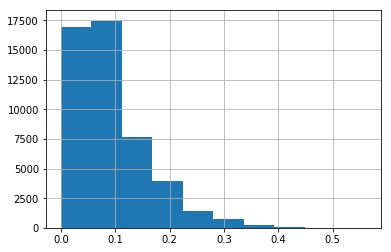

In [49]:
submit_data["TARGET"].hist()

In [50]:
# 未提出IDのデータを抽出
submit_data_tmp=submit_data.copy()
submit_data_tmp["submit"]=1
#submit_data_tmp=submit_data_tmp[["SK_ID_CURR","submit"]].copy()
app_data_tmp=pd.merge(app_data,submit_data_tmp[["SK_ID_CURR","submit"]],on="SK_ID_CURR",how="outer")
app_data_nosubmit=app_data_tmp[(app_data_tmp["TARGET"]!=app_data_tmp["TARGET"])&(app_data_tmp["submit"]!=app_data_tmp["submit"])]
app_data_nosubmit=app_data_nosubmit.replace("XNA",np.nan)
len(app_data_nosubmit)

270

In [51]:
len(app_data[app_data["TARGET"]!=app_data["TARGET"]])-len(submit_data)

270

In [52]:
# 2周目

In [53]:
app_data2=app_data.replace("XNA",np.nan)#.replace("N",np.nan)
# 結合
app_data2=pd.merge(app_data2,bureau_data2,on="SK_ID_CURR",how="outer")
print(len(app_data2))
print(len(app_data2.columns))


# 結合
app_data2=pd.merge(app_data2,POS_data2,on="SK_ID_CURR",how="outer")
print(len(app_data2))
print(len(app_data2.columns))

356255
158
356255
162


In [54]:
app_data2=app_data.replace("XNA",np.nan)#.replace("N",np.nan)

In [55]:
col_lst2=[]
for tmp_col in tqdm(app_data_nosubmit.columns):
#    if app_data_nosubmit[tmp_col].value_counts().sum()/len(app_data_nosubmit) > 0.95:
    if app_data_nosubmit[tmp_col].value_counts().sum()/len(app_data_nosubmit) > 0.9:
        col_lst2.append(tmp_col)
        
print(len(app_data_nosubmit[col_lst2].dropna()))

100%|███████████████████████████████████████| 123/123 [00:00<00:00, 315.76it/s]


234


In [56]:
np.setdiff1d(col_lst2,col_lst1)

array([], dtype='<U27')

In [57]:
col_lst2=grep_not_include(col_lst2,"TARGET")
len(col_lst2)

59

In [58]:
app_data2=app_data[col_lst2].dropna().reset_index(drop=True)
#flag_data=app_data[["SK_ID_CURR","TARGET"]]
app_data2=pd.merge(app_data2,flag_data,on="SK_ID_CURR",how="left")

print(len(app_data2.columns))
print(len(app_data2))

60
353349


In [59]:
tgt_col='CODE_GENDER'
tmp_DF=pd.get_dummies(app_data2[tgt_col])
tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

app_data2=pd.concat([app_data2,tmp_DF],axis=1)
del app_data2[tgt_col]

app_data2["HOUR_APPR_PROCESS_START"]=app_data2["HOUR_APPR_PROCESS_START"].replace(0,24).replace(1,25).replace(2,26)

for tgt_col in grep_startswith(app_data2.columns,"NAME_"):
    #print(tgt_col)
    tmp_DF=pd.get_dummies(app_data2[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

    app_data2=pd.concat([app_data2,tmp_DF],axis=1)
    del app_data2[tgt_col]
    
tgt_col='WEEKDAY_APPR_PROCESS_START'
tmp_DF=pd.get_dummies(app_data2[tgt_col])
tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

app_data2=pd.concat([app_data2,tmp_DF],axis=1)
del app_data2[tgt_col]

app_data2['FLAG_OWN_CAR']=app_data2['FLAG_OWN_CAR'].replace("Y",1).replace("N",0)
app_data2['FLAG_OWN_REALTY']=app_data2['FLAG_OWN_REALTY'].replace("Y",1).replace("N",0)

train_data=app_data2[app_data2["TARGET"]==app_data2["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=10)
model.fit(train_data_x, train_data_y)

305548


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [60]:
eval_data=app_data2[app_data2["TARGET"]!=app_data2["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)
#ypred2=model2.predict_proba(eval_data_x[imp_cols])

47801


In [61]:
submit_data_tmp=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data_tmp.columns=["SK_ID_CURR","TARGET"]
#submit_data.to_csv("submit_data_0527_01.csv",index=False,header=True)
print(len(submit_data_tmp))

47801


In [62]:
submit_data4=pd.merge(app_data_nosubmit[["SK_ID_CURR"]],submit_data_tmp,on="SK_ID_CURR",how="inner")

In [63]:
print(len(app_data_nosubmit))
print(len(submit_data))
print(len(submit_data4))
print(len(submit_data)+len(submit_data4))
print(len(app_test))

print(len(app_test)-len(submit_data)-len(submit_data4))

270
48474
234
48708
48744
36


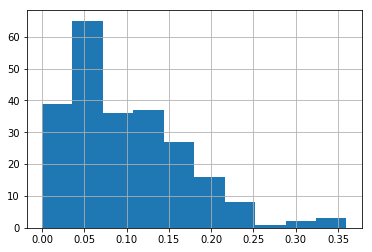

In [64]:
submit_data4["TARGET"].hist()

In [65]:
# 未提出IDのデータを抽出
submit_data_tmp=pd.concat([submit_data,submit_data4])
submit_data_tmp["submit"]=1
#submit_data_tmp=submit_data_tmp[["SK_ID_CURR","submit"]].copy()
app_data_tmp=pd.merge(app_data,submit_data_tmp[["SK_ID_CURR","submit"]],on="SK_ID_CURR",how="outer")
app_data_nosubmit=app_data_tmp[(app_data_tmp["TARGET"]!=app_data_tmp["TARGET"])&(app_data_tmp["submit"]!=app_data_tmp["submit"])]
app_data_nosubmit=app_data_nosubmit.replace("XNA",np.nan)

In [66]:
len(app_data_nosubmit)

36

In [67]:
# 3周目

In [68]:
col_lst3=[]
for tmp_col in tqdm(app_data_nosubmit.columns):
    if app_data_nosubmit[tmp_col].value_counts().sum()/len(app_data_nosubmit) > 0.9:
        col_lst3.append(tmp_col)
        
print(len(app_data_nosubmit[col_lst3].dropna()))
print(len(col_lst3))

100%|███████████████████████████████████████| 123/123 [00:00<00:00, 675.35it/s]


36
60


In [69]:
np.setdiff1d(col_lst3,col_lst1)

array([], dtype='<U27')

In [70]:
app_data2=app_data[col_lst3].dropna().reset_index(drop=True)
flag_data=app_data[["SK_ID_CURR","TARGET"]]
app_data2=pd.merge(app_data2,flag_data,on="SK_ID_CURR",how="left")

print(len(app_data2.columns))
print(len(app_data2))

61
354926


In [71]:
tgt_col='CODE_GENDER'
tmp_DF=pd.get_dummies(app_data2[tgt_col])
tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

app_data2=pd.concat([app_data2,tmp_DF],axis=1)
del app_data2[tgt_col]

app_data2["HOUR_APPR_PROCESS_START"]=app_data2["HOUR_APPR_PROCESS_START"].replace(0,24).replace(1,25).replace(2,26)

for tgt_col in grep_startswith(app_data2.columns,"NAME_"):
    #print(tgt_col)
    tmp_DF=pd.get_dummies(app_data2[tgt_col])
    tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

    app_data2=pd.concat([app_data2,tmp_DF],axis=1)
    del app_data2[tgt_col]
    
tgt_col='WEEKDAY_APPR_PROCESS_START'
tmp_DF=pd.get_dummies(app_data2[tgt_col])
tmp_DF.columns=[tgt_col+"_"+str(x) for x in tmp_DF.columns]

app_data2=pd.concat([app_data2,tmp_DF],axis=1)
del app_data2[tgt_col]

app_data2['FLAG_OWN_CAR']=app_data2['FLAG_OWN_CAR'].replace("Y",1).replace("N",0)
app_data2['FLAG_OWN_REALTY']=app_data2['FLAG_OWN_REALTY'].replace("Y",1).replace("N",0)

train_data=app_data2[app_data2["TARGET"]==app_data2["TARGET"]]
print(len(train_data))

train_data_x=train_data.copy()
del train_data_x["SK_ID_CURR"]
del train_data_x["TARGET"]
train_data_y=train_data["TARGET"]

model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=10)
model.fit(train_data_x, train_data_y)

306211


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [72]:
model = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=10)
model.fit(train_data_x, train_data_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [73]:
eval_data=app_data2[app_data2["TARGET"]!=app_data2["TARGET"]].copy()
print(len(eval_data))
eval_data_x=eval_data.copy()
del eval_data_x["TARGET"]
del eval_data_x["SK_ID_CURR"]
ypred=model.predict_proba(eval_data_x)
#ypred2=model2.predict_proba(eval_data_x[imp_cols])

48715


In [74]:
submit_data_tmp=pd.concat([eval_data.reset_index(drop=True)["SK_ID_CURR"],pd.DataFrame(ypred[:,1])],axis=1)
submit_data_tmp.columns=["SK_ID_CURR","TARGET"]
#submit_data.to_csv("submit_data_0527_01.csv",index=False,header=True)
print(len(submit_data_tmp))

48715


In [75]:
submit_data5=pd.merge(app_data_nosubmit[["SK_ID_CURR"]],submit_data_tmp,on="SK_ID_CURR",how="inner")

In [76]:
print(len(app_data_nosubmit))
print(len(submit_data))
print(len(submit_data4))
print(len(submit_data5))
print(len(app_test)-(len(submit_data)+len(submit_data4)+len(submit_data5)))



36
48474
234
36
0


In [77]:
#app_data3_2=app_data3[app_data3["TARGET"]!=app_data3["TARGET"]]
#app_data3_2["TARGET"]=app_data3["TARGET"].mean()
submit_data6=pd.concat([submit_data,submit_data4,submit_data5]).sort_values("SK_ID_CURR")


In [79]:
print(len(submit_data6))

48744


In [80]:
print(len(submit_data))
print(len(submit_data4))
print(len(submit_data5))
print(len(submit_data6))

48474
234
36
48744


In [84]:
submit_data6=submit_data6.reset_index(drop=True)

In [78]:
#submit_data6.to_csv("credit_submit_data_0602_01.csv",index=False,header=True)
tmp_data=pd.read_csv("credit_submit_data_0602_01.csv")

In [86]:
(submit_data6["TARGET"]-tmp_data["TARGET"]).astype(bool).astype(int).sum()

0

In [764]:
bureau_b_data=pd.read_csv("bureau_balance.csv")

In [765]:
bureau_b_data.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [772]:
POS_data=pd.read_csv("POS_CASH_balance.csv")

In [781]:
POS_data.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


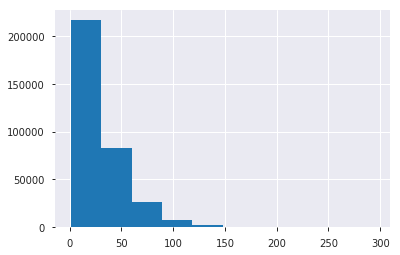

In [779]:
POS_data["SK_ID_CURR"].value_counts().hist()

In [780]:
len(POS_data["SK_ID_CURR"].value_counts())

337252

In [809]:
POS_data.sort_values(["SK_ID_CURR","SK_ID_PREV","CNT_INSTALMENT_FUTURE"]).head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2197888,1369693,100001,-53,4.0,0.0,Completed,0,0
4704415,1369693,100001,-54,4.0,1.0,Active,0,0
7823681,1369693,100001,-55,4.0,2.0,Active,0,0
8789081,1369693,100001,-56,4.0,3.0,Active,0,0
7167007,1369693,100001,-57,4.0,4.0,Active,0,0
4928574,1851984,100001,-93,4.0,0.0,Completed,0,0
8531326,1851984,100001,-94,4.0,0.0,Active,0,0
1891462,1851984,100001,-95,4.0,1.0,Active,7,7
1261679,1851984,100001,-96,4.0,2.0,Active,0,0
6626366,1038818,100002,-1,24.0,6.0,Active,0,0


In [800]:
tmp_data=pd.merge(app_data,POS_data.groupby("SK_ID_CURR").sum()["SK_DPD"].reset_index(),on="SK_ID_CURR",how="inner")
tmp_data=tmp_data[tmp_data["SK_DPD"]>0]
tmp_data["TARGET"].mean()

0.10056141762522174

In [808]:
tmp_data=pd.merge(app_data,POS_data.groupby("SK_ID_CURR").mean()["SK_DPD"].reset_index(),on="SK_ID_CURR",how="inner")
tmp_data=tmp_data[(tmp_data["SK_DPD"]<=8)&(tmp_data["SK_DPD"]>0)]
tmp_data["TARGET"].mean()

0.10169694549810342

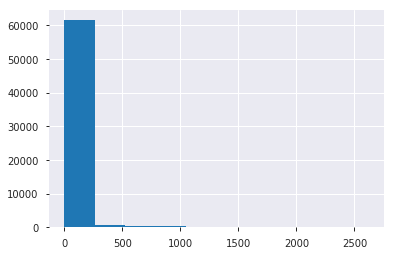

In [803]:
tmp_data["SK_DPD"].hist()

In [801]:
app_data["TARGET"].mean()

0.08072881945686496

In [832]:
# POS_CASHデータの結合

POS_data=pd.read_csv("POS_CASH_balance.csv")

#PREV_IDの数、SK_DPDの合計、SK_DPDの回数、分割数の平均
tmp_data1=POS_data.groupby(["SK_ID_CURR","SK_ID_PREV"]).mean()
tmp_data1["POS_ID_PREV_CNT"]=1
tmp_data1_2=tmp_data1.groupby(["SK_ID_CURR"]).sum()["POS_ID_PREV_CNT"]
tmp_data2=POS_data.groupby(["SK_ID_CURR"]).sum()["SK_DPD"]
POS_data["SK_DPD_CNT"]=POS_data["SK_DPD"].astype(bool).astype(int)
tmp_data3=POS_data.groupby(["SK_ID_CURR"]).sum()["SK_DPD_CNT"]
tmp_data4=tmp_data1.groupby(["SK_ID_CURR"]).sum()["CNT_INSTALMENT"]
POS_data2=pd.concat([tmp_data1_2,tmp_data2,tmp_data3,tmp_data4],axis=1)
POS_data2.columns=['POS_ID_PREV_CNT', 'POS_SK_DPD_SUM', 'POS_SK_DPD_CNT', 'POS_CNT_INSTALMENT_MEAN']
POS_data2=POS_data2.reset_index()

In [836]:
両方あるひと
POSだけのひと
BEAUEだけのひと